### **Introdução**

#### **O que é churn?**

Churn nada mais é do que uma métrica que indica a taxa de cancelamento de clientes em um determinado período, ou seja, quantos deles a sua empresa perdeu por mês, trimestre ou ano, por exemplo.
Em negócios SaaS como o da Telco que cobram mensalmente por um serviço o churn é um problema muito sério, pois se um cliente que paga mensalidade resolve cancelar, o faturamento da empresa a longo prazo está comprometido. 



#### **Objetivo do Modelo**

Iremos analisar dados da Telco com o objetivo de entender, tratar os dados e criar um modelo de machine learning que consiga prever o churn, com isso a empresa terá tembo hábil de tentar recuperar o seu cliente. 

### **Dicionário dos dados**

Dicionário do dataframe

- customerID -> ID do Cliente

- gender -> Se o cliente é homem ou mulher

- SeniorCitizen -> Se o cliente é idoso ou não

- Partner -> Se o cliente tem um parceiro ou não

- Dependents -> Se o cliente tem dependentes ou não

- tenure -> Number of months the customer has stayed with the company

- PhoneService -> Whether the customer has a phone service or not

- MultipleLines -> Se o cliente tem várias linhas ou não

- InternetService -> Provedor de serviço de internet do cliente

- OnlineSecurity -> Se o cliente tem segurança online ou não

- OnlineBackup -> Se o cliente tem backup online ou não

- DeviceProtection -> Se o cliente tem proteção do dispositivo ou não

- TechSupport -> Se o cliente tem suporte técnico ou não

- StreamingTV -> Se o cliente tem streaming de TV ou não

- StreamingMovies -> Se o cliente tem streaming de filmes ou não

- Contract -> O prazo do contrato do cliente

- PaperlessBilling -> Se o cliente tem faturamento sem papel ou não

- PaymentMethod -> A forma de pagamento do cliente

- MonthlyCharges -> O valor cobrado do cliente mensalmente

- TotalCharges -> O valor total cobrado do cliente

- Churn -> Se o cliente cancelou ou não

### **Importando Biblioteca e Dados**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from skopt import gp_minimize
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from datetime import datetime
import pickle

#Funções auxiliares
from functions import *
warnings.filterwarnings("ignore") # Ignorar mensagens de warnings
pd.set_option('display.float_format', lambda x: '%.2f' % x) # não deixar em notação cientifica


In [2]:
telco = pd.read_csv('Telco-Customer-Churn.csv')
now = datetime.now()
dt_string = now.strftime("%d/%m/%Y %H:%M:%S")


### **Conhecendo os dados**

In [3]:
df_informations(telco)

<H3 style='text-align:left;float:lfet;'>Information about the Dataset

<H5> Dataset has 7043 rows and 21 columns. From these, we have:

,Not Null,Null,Perce Null,Unique,Dtype
customerID,7043,0,0.00%,7043,object
gender,7043,0,0.00%,2,object
SeniorCitizen,7043,0,0.00%,2,int64
Partner,7043,0,0.00%,2,object
Dependents,7043,0,0.00%,2,object
tenure,7043,0,0.00%,73,int64
PhoneService,7043,0,0.00%,2,object
MultipleLines,7043,0,0.00%,3,object
InternetService,7043,0,0.00%,3,object
OnlineSecurity,7043,0,0.00%,3,object


<H3 style='text-align:left;float:lfet;'>About Dtypes we have:

,Dtype,Perce
object,18,86.00%
int64,2,10.00%
float64,1,5.00%


1. Observando o output acima conseguimos observar que o dataset não possui valores nulos, dentro do tipo da coluna iremos precisar efetuar a alterações de algumas.

2. A coluna customerID possui somente valores únicos, sendo assim como Python já possui um index númerico iremos removê-la e removeremos também a coluna PaperlessBilling por não possuir valor para a gente.

In [4]:
telco.drop(columns=['customerID', 'PaperlessBilling'],inplace=True)

In [5]:
display(telco)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Mailed check,84.80,1990.5,No
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Credit card (automatic),103.20,7362.9,No
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Electronic check,29.60,346.45,No
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Mailed check,74.40,306.6,Yes


In [6]:
# Alterando coluna TotalCharges para tipo float para não atrapalhar a análise gráfica
# Os valores de TotalCharges é uma string vazia quando Tenure é igual a 0, sendo assim iremos substituir "" por 0 pois o cliente ainda não efetuou o primeiro pagamento
telco.loc[telco['tenure'] == 0, 'TotalCharges'] = 0

# Alterando tipo da colunas para float
telco['TotalCharges'] = telco['TotalCharges'].astype('float64')

### **Análise Gráfica dos dados**

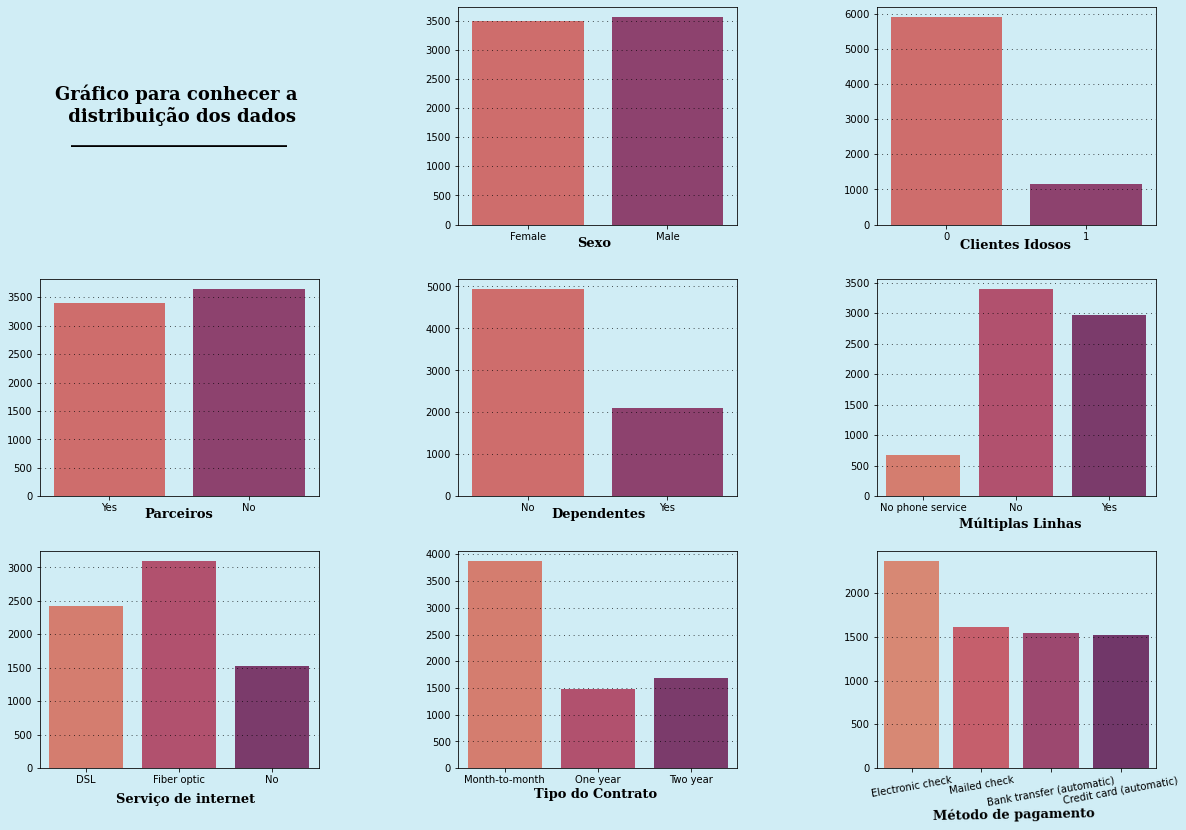

In [7]:
# Definindo Localização e tamanho do gráfico

fig = plt.figure(figsize=(20,14))
gs = fig.add_gridspec(3,3)
gs.update(wspace=0.5, hspace=0.25)
axe0 = fig.add_subplot(gs[0,0])
axe1 = fig.add_subplot(gs[0,1])
axe2 = fig.add_subplot(gs[0,2])
axe3 = fig.add_subplot(gs[1,0])
axe4 = fig.add_subplot(gs[1,1])
axe5 = fig.add_subplot(gs[1,2])
axe6 = fig.add_subplot(gs[2,0])
axe7 = fig.add_subplot(gs[2,1])
axe8 = fig.add_subplot(gs[2,2])

# Selecionando cor de fundo do plot
background_color = "#d0edf5"
fig.patch.set_facecolor(background_color) 
axe0.set_facecolor(background_color) 
axe1.set_facecolor(background_color) 
axe2.set_facecolor(background_color) 
axe3.set_facecolor(background_color) 
axe4.set_facecolor(background_color) 
axe5.set_facecolor(background_color) 
axe6.set_facecolor(background_color) 
axe7.set_facecolor(background_color) 
axe8.set_facecolor(background_color) 

# Titulo do plot
axe0.spines["bottom"].set_visible(False)
axe0.spines["left"].set_visible(False)
axe0.spines["top"].set_visible(False)
axe0.spines["right"].set_visible(False)
axe0.tick_params(left=False, bottom=False)
axe0.set_xticklabels([])
axe0.set_yticklabels([])
axe0.text(0.5,0.5,
         'Gráfico para conhecer a \n distribuição dos dados\n________________________',
         horizontalalignment='center',
         verticalalignment='center',
         fontsize=18, fontweight='bold',
         fontfamily='serif',
         color="#000000")

# Quantidade de clientes por sexo
axe1.text(0.35, -380, 'Sexo', fontsize=13, fontweight='bold', fontfamily='serif', color="#000000")
axe1.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=axe1,data=telco,x='gender', palette="flare")
axe1.set_xlabel("")
axe1.set_ylabel("");

# Quantidade de clientes idosos (Sim: 1, Não: 0)

axe2.text(0.10, -700, 'Clientes Idosos', fontsize=13, fontweight='bold', fontfamily='serif', color="#000000")
axe2.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=axe2,data=telco,x='SeniorCitizen', palette="flare")
axe2.set_xlabel("")
axe2.set_ylabel("");

# Quantidade de clientes com parceiros
axe3.text(0.25, -380, 'Parceiros', fontsize=13, fontweight='bold', fontfamily='serif', color="#000000")
axe3.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=axe3,data=telco,x='Partner', palette="flare")
axe3.set_xlabel("")
axe3.set_ylabel("");

# Quantidade de clientes com dependentes
axe4.text(0.17, -520, 'Dependentes', fontsize=13, fontweight='bold', fontfamily='serif', color="#000000")
axe4.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=axe4,data=telco,x='Dependents', palette="flare")
axe4.set_xlabel("")
axe4.set_ylabel("");

# Quantidade de clientes com múltiplas linhas
axe5.text(0.39, -520, 'Múltiplas Linhas', fontsize=13, fontweight='bold', fontfamily='serif', color="#000000")
axe5.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=axe5,data=telco,x='MultipleLines', palette="flare")
axe5.set_xlabel("")
axe5.set_ylabel("");

# Quantidade de clientes com múltiplas linhas
axe6.text(0.32, -520, 'Serviço de internet', fontsize=13, fontweight='bold', fontfamily='serif', color="#000000")
axe6.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=axe6,data=telco,x='InternetService', palette="flare")
axe6.set_xlabel("")
axe6.set_ylabel("");

# Tipo de contrato dos clientes
axe7.text(0.32, -550, 'Tipo do Contrato', fontsize=13, fontweight='bold', fontfamily='serif', color="#000000")
axe7.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=axe7,data=telco,x='Contract', palette="flare")
axe7.set_xlabel("")
axe7.set_ylabel("");

# Método de pagamento
axe8.text(0.30, -590, 'Método de pagamento',rotation=1, fontsize=13, fontweight='bold', fontfamily='serif', color="#000000")
axe8.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
plt.xticks(rotation=10)
sns.countplot(ax=axe8,data=telco,x='PaymentMethod', palette="flare")
axe8.set_xlabel("")
axe8.set_ylabel("");

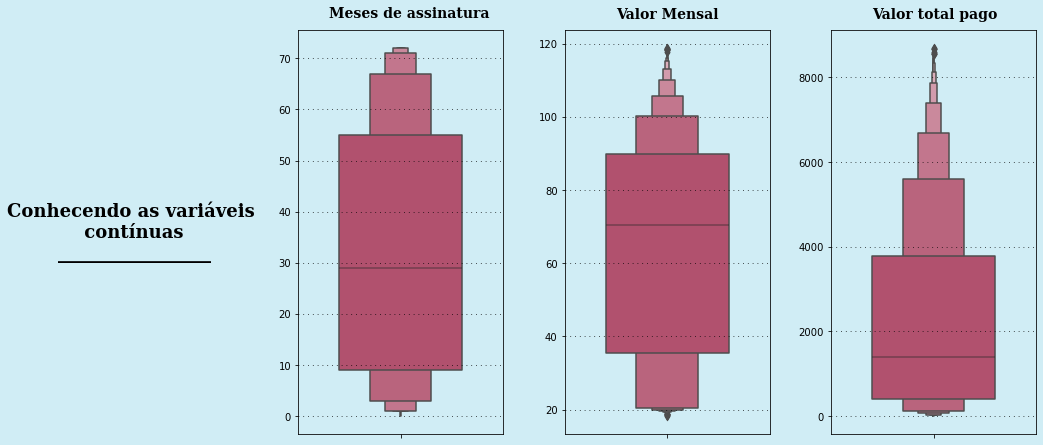

In [8]:
# Definindo localização e tamanho dos gráficos

fig = plt.figure(figsize=(18,16))
gs = fig.add_gridspec(2,4)
gs.update(wspace=0.3, hspace=0.15)
axe0 = fig.add_subplot(gs[0,0])
axe1 = fig.add_subplot(gs[0,1])
axe2 = fig.add_subplot(gs[0,2])
axe3 = fig.add_subplot(gs[0,3])

# Definindo o background do gráfico

background_color = "#d0edf5"
fig.patch.set_facecolor(background_color) 
axe0.set_facecolor(background_color) 
axe1.set_facecolor(background_color) 
axe2.set_facecolor(background_color) 
axe3.set_facecolor(background_color) 

# Título do plot
axe0.spines["bottom"].set_visible(False)
axe0.spines["left"].set_visible(False)
axe0.spines["top"].set_visible(False)
axe0.spines["right"].set_visible(False)
axe0.tick_params(left=False, bottom=False)
axe0.set_xticklabels([])
axe0.set_yticklabels([])
axe0.text(0.5,0.5,
         'Conhecendo as variáveis ​​\n contínuas \n_________________',
         horizontalalignment='center',
         verticalalignment='center',
         fontsize=18, fontweight='bold',
         fontfamily='serif',
         color="#000000")

# Meses de assinatura 
axe1.text(-0.35, 78, 'Meses de assinatura', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
axe1.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxenplot(ax=axe1,y=telco['tenure'],palette="flare",width=0.6)
axe1.set_xlabel("")
axe1.set_ylabel("")

# Valor pago mensal
axe2.text(-0.25, 127, 'Valor Mensal', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
axe2.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxenplot(ax=axe2,y=telco['MonthlyCharges'],palette="flare",width=0.6)
axe2.set_xlabel("")
axe2.set_ylabel("")

# Valor total pago
axe3.text(-0.3, 9400, 'Valor total pago', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
axe3.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxenplot(ax=axe3,y=telco['TotalCharges'],palette="flare",width=0.6)
axe3.set_xlabel("")
axe3.set_ylabel("");



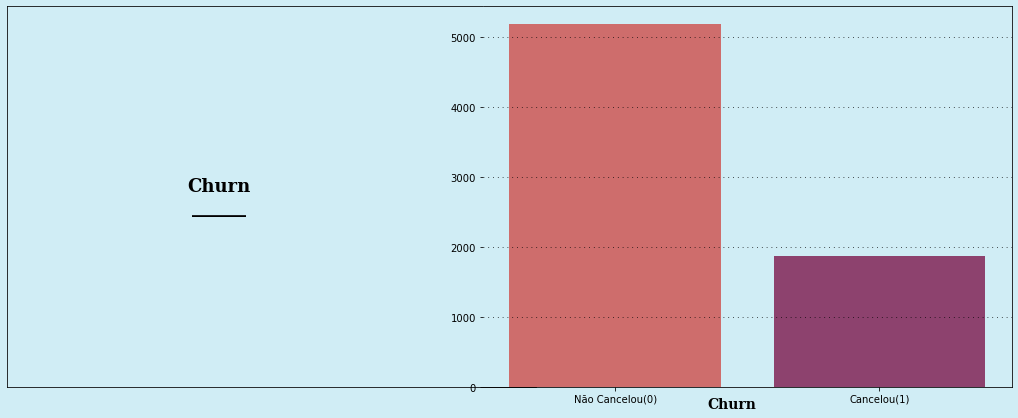

In [9]:
# Definindo localização e tamanho dos gráficos

fig = plt.figure(figsize=(18,7))
gs = fig.add_gridspec(1,2)
gs.update(wspace=-0.1, hspace=0.05)
axe0 = fig.add_subplot(gs[0,0])
axe1 = fig.add_subplot(gs[0,1])

# Definindo cor do background

background_color = "#d0edf5"
fig.patch.set_facecolor(background_color) 
axe0.set_facecolor(background_color) 
axe1.set_facecolor(background_color) 

# Título do plot
axe0.text(0.4,0.5,"Churn\n______",
        horizontalalignment = 'center',
        verticalalignment = 'center',
        fontsize = 18,
        fontweight='bold',
        fontfamily='serif',
        color='#000000')

axe0.set_xticklabels([])
axe0.set_yticklabels([])
axe0.tick_params(left=False, bottom=False)

# Quantidade de Churn
axe1.text(0.35,-300,"Churn",fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
axe1.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=axe1, data=telco, x ='Churn',palette="flare" )
axe1.set_xlabel("")
axe1.set_ylabel("")
axe1.set_xticklabels(["Não Cancelou(0)","Cancelou(1)"])

axe0.spines["right"].set_visible(False)
axe1.spines["left"].set_visible(False)

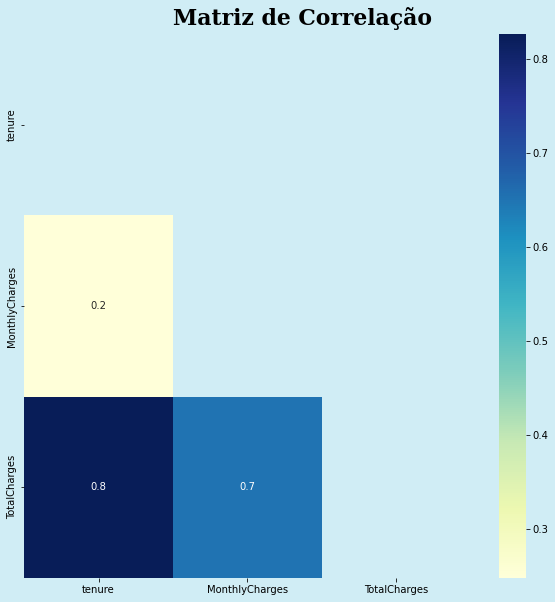

In [10]:
# Escolhendo as colunas que irá participar da matriz de correlação e após isso definindo configuração dos gráficos

Cont_col = ["tenure","MonthlyCharges","TotalCharges"]
Telco_corr = telco[Cont_col].corr().transpose()
fig = plt.figure(figsize=(10,10))
gs = fig.add_gridspec(1,1)
gs.update(wspace=0.3, hspace=0.15)
axe0 = fig.add_subplot(gs[0,0])

background_color = "#d0edf5"
fig.patch.set_facecolor(background_color) 
axe0.set_facecolor(background_color) 

mask = np.triu(np.ones_like(Telco_corr))
axe0.text(1,-0.05,"Matriz de Correlação",fontsize=22, fontweight='bold', fontfamily='serif', color="#000000")
Telco_corr = telco[Cont_col].corr().transpose()
sns.heatmap(Telco_corr,mask=mask,fmt=".1f",annot=True,cmap='YlGnBu')
plt.show()

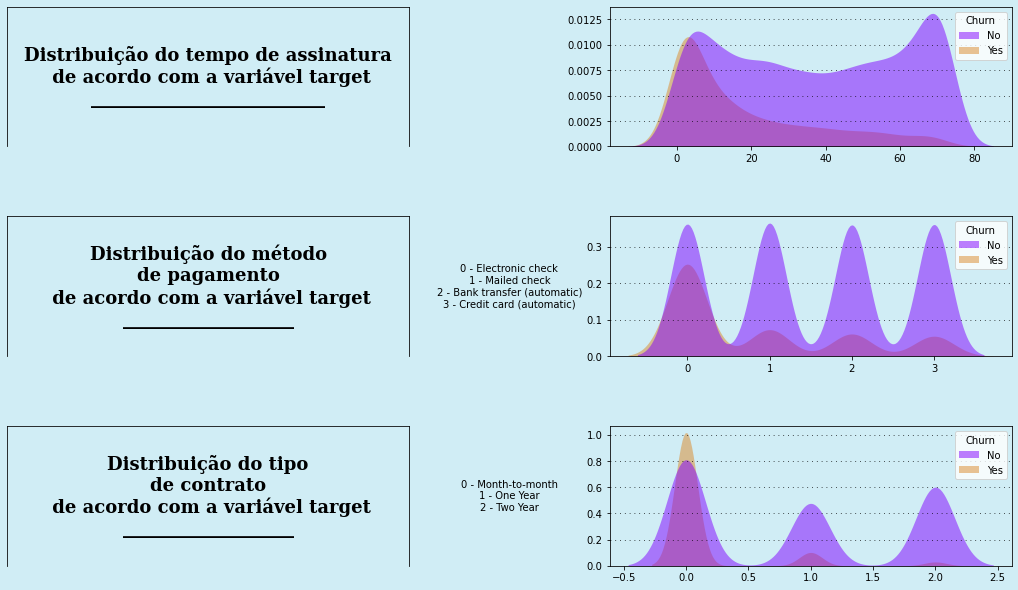

In [11]:
# Definindo tamanho e localização do grupo.
fig = plt.figure(figsize=(18,18))
gs = fig.add_gridspec(5,2)
gs.update(wspace=0.5, hspace=0.5)
axe0 = fig.add_subplot(gs[0,0])
axe1 = fig.add_subplot(gs[0,1])
axe2 = fig.add_subplot(gs[1,0])
axe3 = fig.add_subplot(gs[1,1])
axe4 = fig.add_subplot(gs[2,0])
axe5 = fig.add_subplot(gs[2,1])

# Definindo background do gráfico

background_color = "#d0edf5"
fig.patch.set_facecolor(background_color) 
axe0.set_facecolor(background_color) 
axe1.set_facecolor(background_color) 
axe2.set_facecolor(background_color)
axe3.set_facecolor(background_color)
axe4.set_facecolor(background_color)
axe5.set_facecolor(background_color) 


# Título do gráfico de tempo de assinatura
axe0.text(0.5,0.5,"Distribuição do tempo de assinatura\n de acordo com a variável target\n__________________________",
        horizontalalignment = 'center',
        verticalalignment = 'center',
        fontsize = 18,
        fontweight='bold',
        fontfamily='serif',
        color='#000000')
axe0.spines["bottom"].set_visible(False)
axe0.set_xticklabels([])
axe0.set_yticklabels([])
axe0.tick_params(left=False, bottom=False)

# Plot do gráfico de tempo de assinatura
axe1.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.kdeplot(ax=axe1, data=telco, x='tenure',hue="Churn", fill=True,palette=["#8000ff","#da8829"], alpha=.5, linewidth=0)
axe1.set_xlabel("")
axe1.set_ylabel("")

# Título do gráfico de método de pagamento
axe2.text(0.5,0.5,"Distribuição do método\nde pagamento\n de acordo com a variável target\n___________________",
        horizontalalignment = 'center',
        verticalalignment = 'center',
        fontsize = 18,
        fontweight='bold',
        fontfamily='serif',
        color='#000000')
axe2.spines["bottom"].set_visible(False)
axe2.set_xticklabels([])
axe2.set_yticklabels([])
axe2.tick_params(left=False, bottom=False)

# Subtítulo do gráfico de método de pagamento
axe2.spines["bottom"].set_visible(False)
axe2.set_xticklabels([])
axe2.set_yticklabels([])
axe2.tick_params(left=False, bottom=False)
axe2.text(1.25,0.5,"0 - Electronic check\n1 - Mailed check\n2 - Bank transfer (automatic)\n3 - Credit card (automatic)",
        horizontalalignment = 'center',
         verticalalignment = 'center',
        fontsize = 10
        )

# Fazendo uma função para transformar os valores da coluna em números, e após isso fazer o plot do gráfico.
Telco_plot = telco.copy()
def methodforplot(valor):
    if valor == 'Electronic check':
        return 0
    elif valor == 'Mailed check':
        return 1
    elif valor == 'Bank transfer (automatic)':
        return 2
    else:
        return 3
Telco_plot['PaymentMethod'] = Telco_plot['PaymentMethod'].map(methodforplot)
axe3.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.kdeplot(ax=axe3, data=Telco_plot, x='PaymentMethod',hue="Churn", fill=True,palette=["#8000ff","#da8829"], alpha=.5, linewidth=0)
axe3.set_xlabel("")
axe3.set_ylabel("");


# Título do tipo de contrato
axe4.text(0.5,0.5,"Distribuição do tipo\nde contrato\n de acordo com a variável target\n___________________",
        horizontalalignment = 'center',
        verticalalignment = 'center',
        fontsize = 18,
        fontweight='bold',
        fontfamily='serif',
        color='#000000')
axe4.spines["bottom"].set_visible(False)
axe4.set_xticklabels([])
axe4.set_yticklabels([])
axe4.tick_params(left=False, bottom=False)

# Subtítulo do tipo de contrato 
axe4.spines["bottom"].set_visible(False)
axe4.set_xticklabels([])
axe4.set_yticklabels([])
axe4.tick_params(left=False, bottom=False)
axe4.text(1.25,0.5,"0 - Month-to-month\n1 - One Year\n2 - Two Year",
        horizontalalignment = 'center',
         verticalalignment = 'center',
        fontsize = 10
        )

# Fazendo uma função para transformar os valores da coluna em número, após isso é feito o plot do gráfico
def contractforplot(valor):
    if valor == 'Month-to-month':
        return 0
    elif valor == 'One year':
        return 1
    elif valor == 'Two year':
        return 2

Telco_plot['Contract'] = Telco_plot['Contract'].map(contractforplot)
axe5.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.kdeplot(ax=axe5, data=Telco_plot, x='Contract',hue="Churn", fill=True,palette=["#8000ff","#da8829"], alpha=.5, linewidth=0)
axe5.set_xlabel("")
axe5.set_ylabel("");

##### **Insights da análise gráfica**

**Através dos gráficos acima conseguimos tirar alguns insights alguns deles são:**

1. A distruição dos dados é bem igualitária entre o sexo feminino e masculino.
2. Os cancelamentos normalmente ocorrem no inicio da assinatura, tendo uma queda acentuada por volta dos 10 meses.
3. Dentro dos métodos de pagamento o Electronic check é de longe o que possui a maior quantidade de churn.
4. O contrato mensal tem uma quantidade de churn bem maior que os outros tipos de contratos. 

### **Transformação dos dados**

1. A próxima alteração será alterar valor das colunas, as colunas que possuem até 3 valores irei utilizar uma função para efetuar a alteração com exceção das colunas Contract e MethodPayment pois pelas análises feitas anteriormente elas são muito impactantes para o modelo sendo assim irei utilizar a função do pandas
get_dummies nelas. 

In [12]:
def transform_gender(valor):
    if valor == "Male":
        return 1
    else:
        return 0

def transform_yes_or_not(valor):
    if valor == "Yes":
        return 1
    else:
        return 0

def transform_mlines(valor):
    if valor == "Yes":
        return 1
    elif valor == "No":
        return 0
    else:
        return 2

def transform_iservice(valor):
    if valor == "No":
        return 0
    elif valor == "DSL":
        return 1
    else:
        return 2

# Como as colunas OnlineSecurity, OnlineBackup, DeviceProtection, StreamingTV, StreamingMovies e TechSupport possuem os mesmos valores irei utilizar a função abaixo para todas elas
def transform_osec(valor):
    if valor == "No":
        return 0
    elif valor == "Yes":
        return 1
    else:
        return 2


In [13]:
# Aplicando a função ao dataset para transformar as colunas categoricas.
telco['gender'] = telco['gender'].map(transform_gender)
telco['Partner'] = telco['Partner'].map(transform_yes_or_not)
telco['PhoneService'] = telco['PhoneService'].map(transform_yes_or_not)
telco['MultipleLines'] = telco['MultipleLines'].map(transform_mlines)
telco['InternetService'] = telco['InternetService'].map(transform_iservice)
telco['OnlineSecurity'] = telco['OnlineSecurity'].map(transform_osec)
telco['OnlineBackup'] = telco['OnlineBackup'].map(transform_osec)
telco['DeviceProtection'] = telco['DeviceProtection'].map(transform_osec)
telco['TechSupport'] = telco['TechSupport'].map(transform_osec)
telco['StreamingTV'] = telco['StreamingTV'].map(transform_osec)
telco['StreamingMovies'] = telco['StreamingMovies'].map(transform_osec)
telco['Churn'] = telco['Churn'].map(transform_yes_or_not)
telco['Dependents'] = telco['Dependents'].map(transform_yes_or_not)


In [14]:
# Verificando o dataset após as transformações.
display(telco)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,2,1,0,1,0,0,0,0,Month-to-month,Electronic check,29.85,29.85,0
1,1,0,0,0,34,1,0,1,1,0,1,0,0,0,One year,Mailed check,56.95,1889.50,0
2,1,0,0,0,2,1,0,1,1,1,0,0,0,0,Month-to-month,Mailed check,53.85,108.15,1
3,1,0,0,0,45,0,2,1,1,0,1,1,0,0,One year,Bank transfer (automatic),42.30,1840.75,0
4,0,0,0,0,2,1,0,2,0,0,0,0,0,0,Month-to-month,Electronic check,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,1,1,24,1,1,1,1,0,1,1,1,1,One year,Mailed check,84.80,1990.50,0
7039,0,0,1,1,72,1,1,2,0,1,1,0,1,1,One year,Credit card (automatic),103.20,7362.90,0
7040,0,0,1,1,11,0,2,1,1,0,0,0,0,0,Month-to-month,Electronic check,29.60,346.45,0
7041,1,1,1,0,4,1,1,2,0,0,0,0,0,0,Month-to-month,Mailed check,74.40,306.60,1


- Utilizando a função do Pandas get_dummies nas colunas Contract e PaymentMethod. 

In [15]:
telco = pd.get_dummies(telco, prefix=['Contract', 'PaymentMethod'])

In [16]:
# Verificando as colunas do dataset após o get_dummies
telco.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

In [17]:
# Reorganizando as colunas
telco = telco[['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'MonthlyCharges', 'TotalCharges',
       'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check','Churn']]

### **Criação do Modelo de Machine Learning**

#### **Sobre a construção dos modelos de machine learning**

##### **Modelos que serão utilizados**

**Utilizaremos os modelos:**
- [Random Forest](https://didatica.tech/o-que-e-e-como-funciona-o-algoritmo-randomforest/)
- [XGBoost](https://sigmoidal.ai/xgboost-aprenda-algoritmo-de-machine-learning-em-python/)
- [Gradient Boosting](https://medium.com/equals-lab/uma-breve-introdução-ao-algoritmo-de-machine-learning-gradient-boosting-utilizando-a-biblioteca-311285783099)

##### **Balanceamento dos Dados**

Apesar de ser um modelo de churn que faz com que a variável target seja desbalanceada não iremos balancear os dados para evitar a perda de informações, no lugar disso utilizaremos modelos que conseguem lidar bem com dados desbalanceados e como métrica vamos utilizar a curva ROC.

##### **Métrica de acurácia**

**Característica de Operação do Receptor**

* ROC é uma curva de probabilidade. Ela é criada traçando a taxa verdadeiro-positivo contra a taxa de falsos-positivos. Ou seja, numero de vezes que o classificador acertou a predição conta o número de vezes que o classificador errou a predição.

* O AUC representa o grau ou medida de separabilidade. Quanto maior o AUC, melhor o modelo está em prever 0s como 0s e 1s como 1s. Por exemplo, quanto maior a AUC, melhor o modelo está em distinguir entre pacientes com doença e pacientes sem doença


**Link com mais informações sobre o que é a curva ROC e como utiliza-la [aqui](https://medium.com/@eam.avelar/o-que-é-auc-e-roc-nos-modelos-de-machine-learning-2e2c4112033d)**

#### **Parâmetros gerais dos modelos**

##### **Separação dos dados**

In [18]:
# Separando os dados em X e Y.
X = telco.drop(columns='Churn')
y = telco['Churn']

##### **Feature Selection (Recursive Feature Elimination)**

**O que é o Recursive Feature Elimination (RFE)?**
- Primeiro, o estimador (modelo) é treinado no conjunto inicial de features e a importância de cada uma é obtida através de qualquer atributo específico. Em seguida, as features menos importantes são removidas do conjunto original de features. Esse procedimento é repetido recursivamente no dataset até que o número desejado de características a serem selecionadas seja obtido.

In [19]:
# Selecionando o RandomForestClassifier como modelo para o RFE
model = RandomForestClassifier(n_estimators=500, random_state=1)
RFE_Select = RFE(model, n_features_to_select=15, step=1)
RFE_fit = RFE_Select.fit(X,y)
cols_rfe = RFE_fit.get_support(indices=True)

In [20]:
# Selecionando somente as features selecionadas pelo RFE.

X = X.iloc[:,cols_rfe]

X.rename({'PaymentMethod_Electronic check': 'PaymentMethod_Electronic_check',
         'Contract_Month-to-month':'Contract_Month_to_month'}, axis = 1, inplace=True)

# Separando o dataset em treino e teste para o tunning de hiperparâmetros.

X_train, X_teste, y_train, y_teste = train_test_split(X, y, test_size=0.3, random_state=42)

##### **Cross Validation**

**O que é o Cross Validation (Validação Cruzada)**

<img src="cross-validation.png">

O cross validation (Validação Cruzada) é uma técnica utilizada com o objetivo de avaliar o desempenho de modelo de machine learning, ele divide a base de dados de forma aleatória em um número de conjuntos sendo que esse número é definido no parâmetro, a cada nova iteração é utilizado um conjunto diferente dos dados, evitando assim que o seu modelo sofra de [underfitting](https://didatica.tech/underfitting-e-overfitting/) e [overfitting](https://didatica.tech/underfitting-e-overfitting/). 


- **Link do medium explicando de forma mais completa como funciona o Cross Validation [aqui](https://medium.com/@jvsavietto6/machine-learning-métricas-validação-cruzada-bias-e-variância-380513d97c95)**

- **Abaixo iremos criar uma função para realizar o Cross Validation nos modelos**

In [21]:
def Cross_validation(Modelo, X, y, Resultado):
    for repet in range(15):
        print('Repetição: ', repet)
        kf1 = KFold(4, shuffle=True, random_state=repet)

        for linhas_treino, linhas_valid in kf1.split(X = X, y=y):
            print("Treino", linhas_treino.shape[0]) 
            print("Valid", linhas_valid.shape[0])
        

            X_treino, X_valid = X.iloc[linhas_treino], X.iloc[linhas_valid]
            y_treino, y_valid = y.iloc[linhas_treino], y.iloc[linhas_valid]

            Modelo

            print('Repetição:',repet)
            
            Modelo.fit(X_treino, y_treino)

            p = Modelo.predict(X_valid)
            Resultado.append(roc_auc_score(y_valid, p))
            acc1 = np.mean(p == y_valid)
            Resultado.append(acc1)
            print('Acurácia:', acc1)
            print()

##### **Model Tuning (Bayesian Optimization)**

**Como funciona o [Bayesian Optimization](https://medium.com/@beniciowg/como-tunar-hiperparâmetros-com-otimização-bayesiana-5687fd51370f) ?**

1. Deve-se ser colocado uma faixa de valores a ser testado e a métrica de de avaliação do modelo no nosso caso a **ROC_AUC_SCORE**.

2. Após isso o algoritmo cria um modelo [surrogate](https://deepchecks.com/glossary/surrogate-model/) que estima a função objetiva da métrica selecionada.

3. Após os testes o surrogate é atualizado com a pontuação real obtida para aquele valor de hiperparâmetro, sendo assim a cada interação a função é aperfeiçoada e após todas elas como output da os hiperparâmetro que se saíram melhor. 

#### **Modelo de random Forest**

In [22]:
def treinar_modelo(params):
    max_depth = params[0]
    n_jobs = params[1]
    max_leaf_nodes = params[2]
    max_samples = params[3]

    print(params, '\n')
    

    mdl = RandomForestClassifier(max_depth=max_depth, n_jobs=n_jobs, 
                                 max_leaf_nodes=max_leaf_nodes, 
                                 max_samples=max_samples, n_estimators=600, random_state=42)

    mdl.fit(X_train, y_train)

    p = mdl.predict_proba(X_teste)[:, 1]

    return -roc_auc_score(y_teste, p)


space = [(1, 40), # max_depth
         (1, 11), # n_jobs
         (2, 35), # max_leaf_nodes
         (1, 30)] # max_samples
bayesian_RF = gp_minimize(treinar_modelo, space, n_calls=30, random_state=42, verbose = 0, n_random_starts=10)

[32, 3, 28, 18] 

[18, 2, 17, 11] 

[7, 8, 4, 22] 

[38, 1, 35, 19] 

[25, 1, 3, 16] 

[17, 1, 34, 8] 

[5, 7, 15, 30] 

[19, 10, 24, 14] 

[2, 10, 21, 12] 

[2, 3, 10, 21] 

[40, 11, 35, 30] 

[40, 11, 6, 30] 

[1, 11, 35, 30] 

[35, 11, 5, 9] 

[29, 10, 34, 18] 

[3, 5, 2, 1] 

[40, 9, 2, 1] 

[40, 1, 2, 27] 

[40, 1, 35, 24] 

[14, 11, 2, 25] 

[40, 1, 2, 30] 

[40, 11, 35, 29] 

[40, 11, 35, 22] 

[1, 1, 35, 10] 

[40, 1, 35, 13] 

[39, 10, 33, 20] 

[1, 1, 35, 29] 

[40, 6, 32, 28] 

[40, 4, 34, 29] 

[40, 11, 2, 12] 



**Parâmetros Selecionados**

In [23]:
print('Os parâmetros escolhidos pelo Bayesian Optimization foram:')
print()
print('Max_Depht =',bayesian_RF.x[0])
print('N_jobs =',bayesian_RF.x[1])
print('Max_leaf_nodes =',bayesian_RF.x[2])
print('Max_Samples =',bayesian_RF.x[3])

Os parâmetros escolhidos pelo Bayesian Optimization foram:

Max_Depht = 40
N_jobs = 11
Max_leaf_nodes = 35
Max_Samples = 30


##### **Criação do Modelo** 

Criamos uma lista vazia chamada Result_RF, essa lista tem como objetivo receber os outputs do Cross Validation e dentro dos hiperparâmetros do modelo selecionamos os valores output do Bayesian Optimization.

In [24]:
Result_RF = []
RF_Model = RandomForestClassifier(max_depth = bayesian_RF.x[0],
                                n_jobs = bayesian_RF.x[1],
                                max_leaf_nodes = bayesian_RF.x[2],
                                max_samples = bayesian_RF.x[3],
                                n_estimators=600, random_state=42)

##### **Cross Validation e Curva ROC** 

Iremos utilizar as funções utilizadas anteriormente para realizar o Cross Validation no modelo e após isso fazer o plot da Curva ROC.

In [25]:
Cross_validation(RF_Model, X, y, Result_RF)

Repetição:  0
Treino 5282
Valid 1761
Repetição: 0
Acurácia: 0.7842135150482681

Treino 5282
Valid 1761
Repetição: 0
Acurácia: 0.7932992617830777

Treino 5282
Valid 1761
Repetição: 0
Acurácia: 0.8029528676888131

Treino 5283
Valid 1760
Repetição: 0
Acurácia: 0.8068181818181818

Repetição:  1
Treino 5282
Valid 1761
Repetição: 1
Acurácia: 0.807495741056218

Treino 5282
Valid 1761
Repetição: 1
Acurácia: 0.7853492333901193

Treino 5282
Valid 1761
Repetição: 1
Acurácia: 0.7961385576377058

Treino 5283
Valid 1760
Repetição: 1
Acurácia: 0.7778409090909091

Repetição:  2
Treino 5282
Valid 1761
Repetição: 2
Acurácia: 0.794434980124929

Treino 5282
Valid 1761
Repetição: 2
Acurácia: 0.7876206700738216

Treino 5282
Valid 1761
Repetição: 2
Acurácia: 0.7910278250993753

Treino 5283
Valid 1760
Repetição: 2
Acurácia: 0.7982954545454546

Repetição:  3
Treino 5282
Valid 1761
Repetição: 3
Acurácia: 0.8006814310051107

Treino 5282
Valid 1761
Repetição: 3
Acurácia: 0.7932992617830777

Treino 5282
Valid 1761

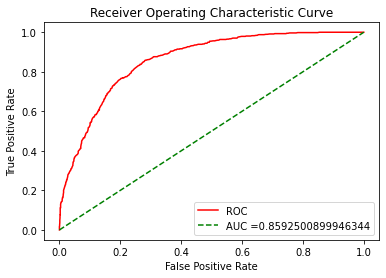

In [27]:
plot_roc_curve(X_teste, y_teste, RF_Model)

#### **Modelo XGBoost**

##### **Model Tuning (Bayesian Optimization)**

In [28]:
def treinar_modelo_XGB(params):
    max_depth = params[0]
    learning_rate = params[1]
    colsample_bytree  = params[2]
    scale_pos_weight  = params[3]
    subsample  = params[2]

    print(params, '\n')
    

    mdl_XGB = XGBClassifier(learning_rate=learning_rate, max_depth=max_depth, 
                            colsample_bytree =colsample_bytree , 
                            scale_pos_weight =scale_pos_weight,
                            subsample = subsample,
                            n_estimators=600, random_state=42)

    mdl_XGB.fit(X_train, y_train)

    p = mdl_XGB.predict_proba(X_teste)[:, 1]

    return -roc_auc_score(y_teste, p)

space_XGB = [(2, 50), # max_depth
             (0.0001, 0.45), # learning_rate
             (0.1, 1), # colsample_bytree
             (0.1, 2), #scale_pos_weight
             (0.5,1)] # subsample

bayesian_XGB = gp_minimize(treinar_modelo_XGB, space_XGB, n_calls=30, random_state=42, verbose = 0, n_random_starts=10)

[40, 0.08262731196078711, 0.8017219002454925, 1.2340153000983256, 0.7229163764267956] 

[7, 0.20671607649544368, 0.40033775002511973, 0.3714469540516875, 0.8254442364744266] 

[5, 0.32492724764284453, 0.9446974381141754, 0.10147965509792722, 0.9961057796456089] 

[32, 0.27528275690367765, 0.10635967469774567, 0.14381860757868994, 0.7623873301291946] 

[21, 0.021094881879805585, 0.9763799669573134, 0.5422655468175781, 0.5453032172664104] 

[32, 0.17216964987109656, 0.9849077972261095, 0.986849497171162, 0.9299702033681604] 

[35, 0.20277961346109744, 0.11193846504387989, 1.8901833358012208, 0.7816441089227697] 

[20, 0.007283216873874368, 0.30780444305993415, 0.5579483854494224, 0.8416317594127292] 

[31, 0.37495439079010046, 0.2560281881569949, 0.8430151543891576, 0.5911180438940312] 

[38, 0.19137762793361104, 0.28714749658137, 1.1786306228579841, 0.5156566462277793] 

[17, 0.0001, 0.2668065973102153, 2.0, 0.7803222648159591] 

[37, 0.006331364985572821, 0.5071425187834626, 0.14199123

**Parâmetros Selecionados**

In [29]:
print('Os parâmetros escolhidos pelo Bayesian Optimization foram:')
print()
print('Max Depht =',bayesian_XGB.x[0])
print('Learning Rate =',bayesian_XGB.x[1])
print('Colsample By Tree =',bayesian_XGB.x[2])
print('Scale pos Weight =',bayesian_XGB.x[3])
print('Subsample =',bayesian_XGB.x[4])

Os parâmetros escolhidos pelo Bayesian Optimization foram:

Max Depht = 37
Learning Rate = 0.006331364985572821
Colsample By Tree = 0.5071425187834626
Scale pos Weight = 0.1419912387631036
Subsample = 1.0


##### **Criação do Modelo**

In [30]:
Result_XGB = []
XGB_Model = XGBClassifier(max_depth = bayesian_XGB.x[0],
                          learning_rate = bayesian_XGB.x[1],
                          colsample_bytree = bayesian_XGB.x[2],
                          scale_pos_weight = bayesian_XGB.x[3],
                          subsample = bayesian_XGB.x[4],
                          n_estimators=600, random_state=42)


##### **Cross Validation e Curva ROC** 

In [31]:
Cross_validation(XGB_Model, X, y, Result_XGB)

Repetição:  0
Treino 5282
Valid 1761
Repetição: 0
Acurácia: 0.7541169789892107

Treino 5282
Valid 1761
Repetição: 0
Acurácia: 0.737649063032368

Treino 5282
Valid 1761
Repetição: 0
Acurácia: 0.7461669505962522

Treino 5283
Valid 1760
Repetição: 0
Acurácia: 0.7653409090909091

Repetição:  1
Treino 5282
Valid 1761
Repetição: 1
Acurácia: 0.768313458262351

Treino 5282
Valid 1761
Repetição: 1
Acurácia: 0.7416240772288473

Treino 5282
Valid 1761
Repetição: 1
Acurácia: 0.7461669505962522

Treino 5283
Valid 1760
Repetição: 1
Acurácia: 0.7471590909090909

Repetição:  2
Treino 5282
Valid 1761
Repetição: 2
Acurácia: 0.7688813174332766

Treino 5282
Valid 1761
Repetição: 2
Acurácia: 0.7336740488358887

Treino 5282
Valid 1761
Repetição: 2
Acurácia: 0.7654741624077229

Treino 5283
Valid 1760
Repetição: 2
Acurácia: 0.74375

Repetição:  3
Treino 5282
Valid 1761
Repetição: 3
Acurácia: 0.7586598523566156

Treino 5282
Valid 1761
Repetição: 3
Acurácia: 0.7546848381601363

Treino 5282
Valid 1761
Repetição:

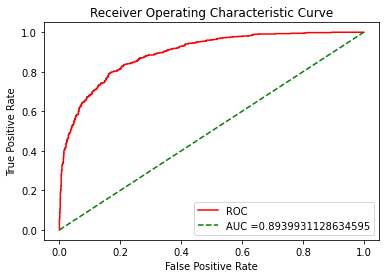

In [32]:
plot_roc_curve(X_teste, y_teste, XGB_Model)

#### **Gradient Boosting**

##### **Model Tuning (Bayesian Optimization)**

In [33]:
def treinar_modelo_GB(params):
    learning_rate = params[0]
    max_depth = params[1]
    max_leaf_nodes = params[2]
    subsample = params[3]

    print(params, '\n')
    

    mdl = GradientBoostingClassifier(learning_rate=learning_rate, max_depth=max_depth, 
                                    max_leaf_nodes=max_leaf_nodes, 
                                    subsample=subsample, n_estimators=600, random_state=42)

    mdl.fit(X_train, y_train)

    p = mdl.predict_proba(X_teste)[:, 1]

    return -roc_auc_score(y_teste, p)


space = [(0.001, 0.15), # learning_rate
         (2, 50), # max_depth
         (2, 35), # max_leaf_nodes
         (0.1, 1)] # subsample
bayesian_GB = gp_minimize(treinar_modelo_GB, space, n_calls=30, random_state=42, verbose = 0, n_random_starts=10)

[0.11968490504217472, 11, 28, 0.6371651421518384] 

[0.06742908017518509, 7, 17, 0.40033775002511973] 

[0.02228715587036918, 33, 4, 0.7497988950401424] 

[0.1408443536433468, 2, 35, 0.655733358664945] 

[0.09213632091275387, 2, 3, 0.5722971942325503] 

[0.06057928478557308, 4, 34, 0.3094942063872739] 

[0.0145003587453903, 32, 15, 0.9849077972261095] 

[0.07054767109394902, 43, 24, 0.5054493267725888] 

[0.0029764792128201133, 47, 21, 0.4468748522859246] 

[0.003378971580811915, 13, 10, 0.7149371669429125] 

[0.03544598427910648, 48, 12, 0.1] 

[0.15, 45, 3, 0.10000000000000006] 

[0.08440764235462637, 42, 34, 0.6596346962238319] 

[0.001, 9, 35, 0.9541369269287983] 

[0.011490082498858176, 31, 2, 0.279030857537666] 

[0.001, 21, 33, 0.3023586566286173] 

[0.001, 40, 2, 0.1] 

[0.04029270106327774, 26, 17, 0.7399195210188377] 

[0.001, 50, 9, 0.9734279371302602] 

[0.01944387725483379, 2, 2, 0.12302582887784058] 

[0.001, 50, 35, 0.1] 

[0.026176089489375682, 2, 35, 0.1607602969438873

In [34]:
print('Os parâmetros escolhidos pelo Bayesian Optimization foram:')
print()
print('learning_rate =',bayesian_GB.x[0])
print('max_depth =',bayesian_GB.x[1])
print('max_leaf_nodes =',bayesian_GB.x[2])
print('subsample =',bayesian_GB.x[3])

Os parâmetros escolhidos pelo Bayesian Optimization foram:

learning_rate = 0.037129847480885235
max_depth = 2
max_leaf_nodes = 2
subsample = 0.5322492805967881


In [35]:
Result_GB = []
GB_Model = GradientBoostingClassifier(learning_rate = bayesian_GB.x[0],
                                      max_depth = bayesian_GB.x[1],
                                      max_leaf_nodes = bayesian_GB.x[2],
                                      subsample  = bayesian_GB.x[3],
                                      n_estimators=600, random_state=42)

In [36]:
Cross_validation(GB_Model, X, y, Result_GB)

Repetição:  0
Treino 5282
Valid 1761
Repetição: 0
Acurácia: 0.794434980124929

Treino 5282
Valid 1761
Repetição: 0
Acurácia: 0.8086314593980692

Treino 5282
Valid 1761
Repetição: 0
Acurácia: 0.8131743327654741

Treino 5283
Valid 1760
Repetição: 0
Acurácia: 0.8073863636363636

Repetição:  1
Treino 5282
Valid 1761
Repetição: 1
Acurácia: 0.807495741056218

Treino 5282
Valid 1761
Repetição: 1
Acurácia: 0.7978421351504826

Treino 5282
Valid 1761
Repetição: 1
Acurácia: 0.8080636002271436

Treino 5283
Valid 1760
Repetição: 1
Acurácia: 0.7926136363636364

Repetição:  2
Treino 5282
Valid 1761
Repetição: 2
Acurácia: 0.8086314593980692

Treino 5282
Valid 1761
Repetição: 2
Acurácia: 0.8006814310051107

Treino 5282
Valid 1761
Repetição: 2
Acurácia: 0.8052243043725156

Treino 5283
Valid 1760
Repetição: 2
Acurácia: 0.8045454545454546

Repetição:  3
Treino 5282
Valid 1761
Repetição: 3
Acurácia: 0.8126064735945485

Treino 5282
Valid 1761
Repetição: 3
Acurácia: 0.8035207268597387

Treino 5282
Valid 1761

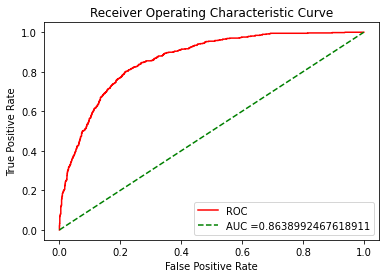

In [37]:
plot_roc_curve(X_teste, y_teste, GB_Model)

#### **Comparar Modelo**

Iremos plotar o gráfico de todas as curvas ROC juntos com o objetivo de verificar qual modelo se saiu melhor. 

<Figure size 432x288 with 0 Axes>

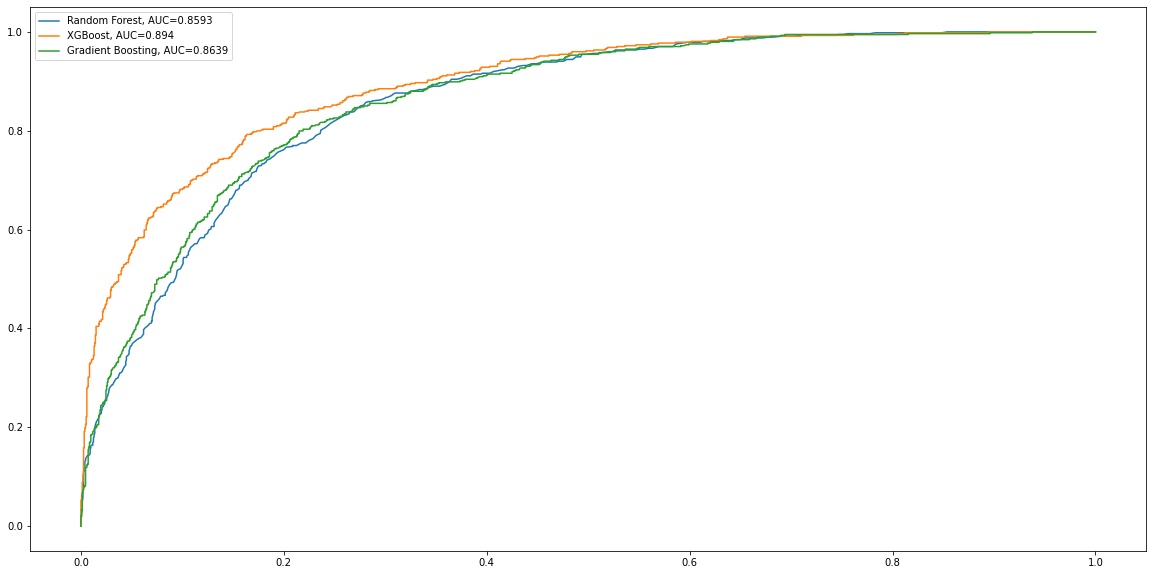

In [38]:
#set up plotting area
plt.figure(0).clf();
plt.figure(figsize=(20, 10));
#fit Random Forest model and plot ROC curve

y_pred = RF_Model.predict_proba(X_teste)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_teste, y_pred)
auc = round(metrics.roc_auc_score(y_teste, y_pred), 4)
plt.plot(fpr,tpr,label="Random Forest, AUC="+str(auc))

#fit XGBoost model and plot ROC curve

y_pred = XGB_Model.predict_proba(X_teste)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_teste, y_pred)
auc = round(metrics.roc_auc_score(y_teste, y_pred), 4)
plt.plot(fpr,tpr,label="XGBoost, AUC="+str(auc))

# Fit Gradient Boosting Model and plot ROC Curve
y_pred = GB_Model.predict_proba(X_teste)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_teste, y_pred)
auc = round(metrics.roc_auc_score(y_teste, y_pred), 4)
plt.plot(fpr,tpr,label="Gradient Boosting, AUC="+str(auc))

#add legend
plt.legend();

#### **Exportando o Modelo**

Dentro dos modelos testados o que se saiu melhor foi o de XGBoost, sendo assim iremos utilizar a biblioteca Pickle para exportar o modelo e futuramente fazer o deploy. 

In [39]:
Model_Pickle = {'Model' : XGB_Model,
                'Data_Modelo' : dt_string,
                'X_train' : X_train,
                'y_train' : y_train}

In [40]:
with open('Telco_Churn.pkl', 'wb') as file:
    pickle.dump(Model_Pickle, file)